In [1]:
from utils import * 
from src.files.blast import BLASTFileGgKbase
import glob
import parasail 
import math  

%load_ext autoreload 
%autoreload 2

# One thought I had is that maybe the fact that Borgs seem to participate in the boom and bust is because the betazoid is hijacking the capsid
# machinery; like maybe Borgs are encapsulated and excreted normally at baseline levels, but then the betazoid causes them to increase their 
# activity way above normal. 

In [2]:
genome_id_to_ggkbase_id_map = dict()
genome_id_to_ggkbase_id_map['bz_0'] = 'Final_SR-VP_05_06_2024_coassembly_19kb_linear_ECE_26_1334_complete' # Original Bz identified in the bioreactors. 
genome_id_to_ggkbase_id_map['bz_1'] = 'Final_Landfill_SRR22315504_19kb_linear_ECE_related_22_47_complete' # Curated from landfill by Ling-Dong.


In [26]:
# Results of BLASTn against all projects in ggKbase.
blast_df = list()
for path in glob.glob('../data/blast/ggkbase/*'): 
    df = BLASTFileGgKbase.from_file(path).to_df().assign(database='ggkbase')
    df['query_id'] = os.path.basename(path).replace('.txt', '')
    blast_df.append(df)
blast_df = pd.concat(blast_df)
blast_df['query_coverage'] = (blast_df.alignment_length - blast_df.n_gaps) / blast_df.query_length
blast_df = blast_df.drop_duplicates(['query_id', 'feature_id']) # Duplicates for some reason, probably relating to how the BLAST search works. 
# blast_df = blast_df[~blast_df.feature_id.str.contains('SR-VP|SRVP', regex=True)].copy()

# Concerned that my BLAST search did not turn up any hits in the SRR22315504 sample, where we have confirmed an ECE. 
# Perhaps not enough alignments generated. 

In [28]:
def get_location(contig_id:str):
    patterns = dict()
    patterns['SR1-|SRVP|SR-VP'] = 'serpens_ridge'
    patterns['Nantong'] = 'nantong_groundwater'
    patterns['RES'] = 'rice_experimental_station'
    patterns['rifcsphigho|RifSed|rbg_19ft_|rifcsp|Rifle|19ft_2_nophage_noknown|16ft_4'] = 'rifle_colorado_sediment'
    patterns['rifcsplow'] = 'rifle_low_o2_groundwater'
    patterns['GWD|GWC|gwd|gwc|GWB|gwb|gwe'] = 'rifle_groundwater'
    patterns['rifoxy'] = 'rifle_colorado_injection_experiment'
    patterns['SPOT'] = 'san_pedro_ocean_time_series'
    patterns['13_2|14_0929|14_1009'] = 'angelo_meadow_soil'
    patterns['Mayberry'] = 'mayberry'
    # patterns[r'L\d_\d\d\d_'] = 'nih_long_term_public_release' # These seem to be infant gut. 
    patterns['CattleFarmer|Cow|GiantTortoise|pig_|Pig_Intestine|FL-1|FM_L-1_|HS'] = 'animal_gut'
    patterns['aquifer_sediment'] = 'aquifer_sediment'
    patterns['Quanzhou_Groundwater'] = 'quanzhou_groundwater'
    patterns['Petroleum-contam_soil'] = 'petroleum_contaminated_soil'
    patterns['Lake_Superior_sediment'] = 'lake_superior_sediment'
    patterns['DolZOral'] = 'dolphin_mouth'
    patterns['zodeltone|Zodletone_Water'] = 'zodletone_water'
    patterns[r'L\d_\d\d\d_|Tanzania|NIMO|N4_'] = 'human_gut' # Not totally sure about the N4_ contigs. 
    patterns['amazon_plume_'] = 'amazon_plume'
    patterns['Landfill'] = 'landfill'
    patterns['Mangrove'] = 'mangrove_soil'
    patterns['EukViruses|M04_|HugePhage|JS_LAK4|aot2015|spain|M10'] = 'viruses' # M04_ and M10 is a phage in baboon gut; Lak phage. aot2015 is phage in human gut. spain match is a phage in human gut. 
    # patterns['SW_scaffold_'] = 'amundson_desert'
    patterns['SW_scaffold_'] = 'not_sure_but_important' # LAC is Lisa Alvarez-Cohen bioreactor data.
    patterns['SacSanJoaquinDelta|SacSanJoaqDelta'] = 'san_joaquin_delta'
    # patterns['js4906-27-3'] = 'arsenic_human_gut'
    patterns['QZM'] = 'tibet_hot_springs'
    patterns['GOSHIP'] = 'goship'
    patterns['Yulin_Groundwater'] = 'yulin_groundwater'
    patterns['XiAn_Groundwater'] = 'xian_groundwater'
    patterns['Dalian_Groundwater'] = 'dalian_groundwater'
    patterns['Beijing_Groundwater'] = 'beijing_groundwater'
    patterns['FFC|MISA|RHP|RTP'] = 'canada_mining_impacted_water' # RTP is a phage bin. 
    patterns['Bodega_Bay_wetland'] = 'bodega_bay_wetland'
    # patterns['SZMB11_|FM-1_|HS2274O|PoF-Drought|N4_166|WE-1|RES|AWTP2|HMP-|J1_AP2|NANO_2|N3_173|GL2|AB_092018'] = 'ignore'
    patterns['LacPavin'] = 'lake_pavin'
    patterns['StrawCreek'] = 'strawberry_creek'
    patterns['Oak_Ridge_Sediment'] = 'oak_ridge_sediment'
    patterns['LAC_|anamox'] = 'anamox_bioreactor'
    patterns['PH2015'] = 'eel_river_mats'
    patterns['Rotsee|ERR3687830'] = 'rotsee_lake'
    patterns['water-treatment'] = 'wastewater'
    patterns['Endo'] = 'arman_china_mexico' # Not sure what this is.
    patterns['BC_09102017|BC_09192017'] = 'syncrude_oil_sands'
    patterns['L2c1|L2c2|L3c|U2|ERMLT'] = 'east_river_soil'
    patterns['EastRiver'] = 'east_river_hyporheic_zone'
    patterns['Mad1'] = 'rivendell_hillslope' # This is a phage genome. 
    patterns['PLM4'] = 'east_river_hillslope'
    patterns['CG18'] = 'crystal_geyser'

    for pattern, location in patterns.items():
        if re.search(pattern, contig_id) is not None:
            return location 
    return 'none'

blast_df['location'] = blast_df.feature_id.apply(get_location)
blast_df['contig_id'] = ['_'.join(feature_id.split('_')[:-1]) for feature_id in blast_df.feature_id]


In [30]:
blast_df[blast_df.location == 'mayberry']
blast_df[blast_df.feature_id.str.contains('Mayberry')]

,feature_number,feature_id,subject_length,bit_score,e_value,n_identical,alignment_length,n_gaps,percent_identity,query_id,query_length,database,query_coverage,location,contig_id
0,128941812,Mayberry_contig_91_7252045_length_5790_multi_2...,453,113.0,1.0,185,266,12,0.695489,bz_0.1_31,450,ggkbase,0.564444,mayberry,Mayberry_contig_91_7252045_length_5790_multi_2...
0,128941808,Mayberry_contig_91_7252045_length_5790_multi_2...,750,285.0,7.0,513,742,16,0.691375,bz_0.1_35,771,ggkbase,0.941634,mayberry,Mayberry_contig_91_7252045_length_5790_multi_2...
0,128941814,Mayberry_contig_91_7252045_length_5790_multi_2...,327,96.0,3.0,162,229,7,0.707424,bz_0.1_29,309,ggkbase,0.718447,mayberry,Mayberry_contig_91_7252045_length_5790_multi_2...
0,128941813,Mayberry_contig_91_7252045_length_5790_multi_2...,684,450.0,2.0,476,622,4,0.765273,bz_0,19040,ggkbase,0.032458,mayberry,Mayberry_contig_91_7252045_length_5790_multi_2...
1,128941808,Mayberry_contig_91_7252045_length_5790_multi_2...,750,285.0,2.0,513,742,16,0.691375,bz_0,19040,ggkbase,0.038130,mayberry,Mayberry_contig_91_7252045_length_5790_multi_2...
2,128941807,Mayberry_contig_91_7252045_length_5790_multi_2...,435,214.0,3.0,256,346,4,0.739884,bz_0,19040,ggkbase,0.017962,mayberry,Mayberry_contig_91_7252045_length_5790_multi_2...
4,128941812,Mayberry_contig_91_7252045_length_5790_multi_2...,453,113.0,7.0,185,266,12,0.695489,bz_0,19040,ggkbase,0.013340,mayberry,Mayberry_contig_91_7252045_length_5790_multi_2...
5,128941814,Mayberry_contig_91_7252045_length_5790_multi_2...,327,96.0,2.0,162,229,7,0.707424,bz_0,19040,ggkbase,0.011660,mayberry,Mayberry_contig_91_7252045_length_5790_multi_2...
0,128941813,Mayberry_contig_91_7252045_length_5790_multi_2...,684,450.0,7.0,476,622,4,0.765273,bz_0.1_30,684,ggkbase,0.903509,mayberry,Mayberry_contig_91_7252045_length_5790_multi_2...
169,128871188,Mayberry_contig_81_7972910_length_2564_multi_1...,2136,47.3,2.9,49,62,2,0.790323,bz_0.1_30,684,ggkbase,0.087719,mayberry,Mayberry_contig_81_7972910_length_2564_multi_1...


In [5]:
exclude_locations = ['animal_gut', 'human_gut', 'none', 'serpens_ridge', 'goship', 'viruses', 'dolphin_mouth']
exclude_locations += ['anamox_bioreactor', 'oak_ridge_sediment', 'rotsee_lake', 'wastewater', 'strawberry_creek']
exclude_locations += ['arman_china_mexico', 'bodega_bay_wetland', 'san_pedro_ocean_time_series']

mask = (blast_df.query_coverage > 0.3) | (blast_df.alignment_length > 100)
mask = mask & (~blast_df.location.isin(exclude_locations))
print('Num. locations:', blast_df[mask].location.nunique())
print('Num. matched genes:', blast_df[mask].query_id.nunique())
print('Num. matched contigs:', blast_df[mask].contig_id.nunique())

Num. locations: 31
Num. matched genes: 32
Num. matched contigs: 429


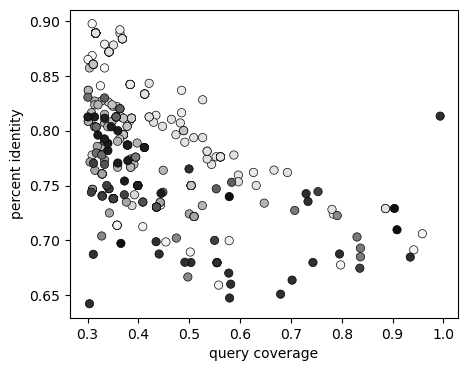

In [6]:
locations = blast_df.location.unique()

# Only good hits in this location are to bz_0.1_3, which is a putative transcription factor. One of the hits is to a contig around 25000 bp in length, 
# but the predicted genes don't match up with the betazoid. 

mask = (blast_df.query_coverage > 0.3) & (~blast_df.location.isin(exclude_locations))
figure_df = blast_df[mask].copy() 
figure_df = figure_df[~figure_df.location.isin(exclude_locations)].copy()
# Nearly every hit in animal guts is to  bz_0.1_11, bz_0.1_10, or bz_0.1_18. Worth noting that some of these are binned as phages. 
# 1_10 and 1_18 are membrane-associated. Their prevalence, particularly in animal guts, makes me think they might be general phage proteins. 

# 1_20 is the DNA polymerase! And 1_35 is the potential packaging NTPase. 1_14 is a potential transcription factor. 
figure_df['n_hits'] = figure_df.query_id.map(figure_df.groupby('query_id').size())
figure_df = figure_df[figure_df.n_hits > 3].copy()

fig, ax = plt.subplots(figsize=(5, 4))
# sns.kdeplot(figure_df, x='percent_identity', hue='query_id', palette='Grays', warn_singular=False)
sns.scatterplot(figure_df, x='query_coverage', y='percent_identity', hue='query_id', palette='Grays', edgecolor='black', legend=False)
# ax.set_ylabel('density')
# ax.set_xlabel('percent identity')
ax.set_ylabel('percent identity')
ax.set_xlabel('query coverage')
# ax.get_legend().set_title('')
plt.show()


In [7]:

# Going to be very lenient about query coverage to start. 
mask =(~blast_df.location.isin(exclude_locations)) &  (blast_df.query_coverage > 0.3) 

def plot_hit_distribution(df:pd.DataFrame):
    figure_df = df.copy()
    figure_df = pd.crosstab(figure_df.query_id, figure_df.location)

    fig, ax = plt.subplots(figsize=(0.3 * len(figure_df.columns), 0.3 * len(figure_df)))

    figure_df_ = pd.DataFrame(figure_df > 0, index=figure_df.index, columns=figure_df.columns)
    col_idxs = np.argsort(figure_df_.values.sum(axis=0))[::-1]
    row_idxs = np.argsort([int(gene_id.split('_')[-1]) for gene_id in figure_df.index])

    figure_df_ = figure_df_.iloc[row_idxs, col_idxs]
    figure_df = figure_df.iloc[row_idxs, col_idxs]
    sns.heatmap(figure_df_, cmap=['white', 'steelblue'], annot=figure_df, fmt='d', cbar=False, lw=0.7, linecolor='black', ax=ax)
    ax.set_ylabel('')
    ax.set_xlabel('')
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    plt.show()
    print('\n'.join(figure_df.columns[:-5]))

# Inspection of some of the hits, particularly those in the animal guts, suggests that bz_0.1_10 and 1_11 might just be general phage proteins. 
# Seems like some of the locations are better than others as far as potential betazoid candidates go. 

In [8]:
blast_df[blast_df['feature_id'].str.contains('149605')]
# blast_df


,feature_number,feature_id,subject_length,bit_score,e_value,n_identical,alignment_length,n_gaps,percent_identity,query_id,query_length,database,query_coverage,location,contig_id


In [9]:
# Get the contig IDs which seem to have promising hits for the betazoid. 
contig_ids = blast_df[((blast_df.alignment_length > 100) | (blast_df.query_coverage > 0.3)) & (~blast_df.location.isin(exclude_locations))].contig_id.unique()
with open('../data/contig_ids.txt', 'w') as f:
    np.savetxt(f, contig_ids, delimiter='\n', fmt='%s')

def run_prodigal(contig_id:str, dir_:str='../data/seed_contigs/'):
    input_path = os.path.join(dir_, 'fasta', f'{contig_id}.fasta')
    output_path = os.path.join(dir_, 'gff', f'{contig_id}.gff')
    cmd = f'prodigal -p meta -i {input_path}.fasta -f gff -o {output_path}'
    subprocess.run(cmd, shell=True, check=True)

def load_gff(contig_id:str, dir_:str='../data/seed_contigs/'):
    path = os.path.join(dir_, 'gff', f'{contig_id}.gff')
    cols = ['contig_id', 'version', 'feature_type', 'start', 'stop', 'score', 'strand', 'frame', 'description']
    df = pd.read_csv(path, comment='#', names=cols, sep='\t')
    return df

get_n_genes = lambda contig_id : len(load_gff(contig_id))
get_strand_bias = lambda contig_id : load_gff(contig_id).strand.value_counts(normalize=True).max()
get_n_strand_switches = lambda contig_id : len(re.findall(r'(\+\-)|(\-\+)', ''.join(load_gff(contig_id).strand.tolist())))
# for contig_id in contig_ids:
#     run_prodigal(contig_id)

In [10]:

get_gc_content = lambda seq : (seq.count('G') + seq.count('C')) / len(seq)
get_hits = lambda contig_id : ' '.join(blast_df[blast_df.contig_id == contig_id].query_id.unique())

contigs_df = list()
for path in glob.glob('../data/seed_contigs/fasta/*fasta'):
    contigs_df.append(FASTAFile.from_file(path).to_df())

MAX_GC_CONTENT = 0.3
MAX_LENGTH = 25 * 1000 # Probably nothing bigger than 25 kb. 

contigs_df = pd.concat(contigs_df)
contigs_df['strand_bias'] = [get_strand_bias(contig_id) for contig_id in contigs_df.index]
contigs_df['n_strand_switches'] = [get_n_strand_switches(contig_id) for contig_id in contigs_df.index]
contigs_df['n_genes'] = [get_n_genes(contig_id) for contig_id in contigs_df.index]
contigs_df['length'] = contigs_df.seq.apply(len)
contigs_df['gc_content'] = contigs_df.seq.apply(get_gc_content)
contigs_df['n_hits'] = contigs_df.index.map(blast_df.groupby('contig_id').size()) # Number of hits for the betazoid on each contig. 
contigs_df['hits'] = [get_hits(contig_id) for contig_id in contigs_df.index]
contigs_df['location'] = [get_location(contig_id) for contig_id in contigs_df.index]

print(f'Removing {(contigs_df.gc_content >= MAX_GC_CONTENT).sum()} contigs exceeding a GC content of {MAX_GC_CONTENT}.')
print(f'Removing {(contigs_df.length >= MAX_LENGTH).sum()} contigs exceeding a maximum length of {MAX_LENGTH} bp.')
print(f'Removing {(contigs_df.n_strand_switches > 3).sum()} contigs with more than three strand switches.')
contigs_df = contigs_df[contigs_df.gc_content < MAX_GC_CONTENT].copy() # Don't think it is likely for GC content above 0.3 to be worth looking into.
contigs_df = contigs_df[contigs_df.length < MAX_LENGTH].copy() 
contigs_df = contigs_df[contigs_df.n_strand_switches < 4].copy()

print(f'\nNum. contigs in final seed dataset:', contigs_df.index.nunique())

contigs_df.to_csv('../data/seed_contigs.csv')

Removing 173 contigs exceeding a GC content of 0.3.
Removing 41 contigs exceeding a maximum length of 25000 bp.
Removing 53 contigs with more than three strand switches.

Num. contigs in final seed dataset: 228


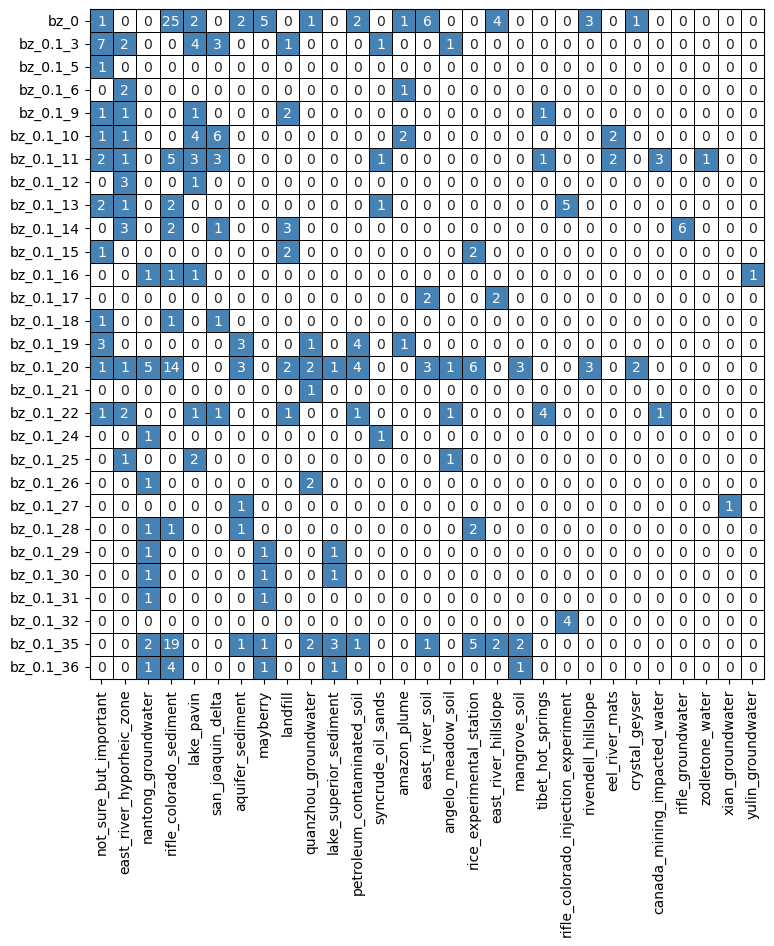

not_sure_but_important
east_river_hyporheic_zone
nantong_groundwater
rifle_colorado_sediment
lake_pavin
san_joaquin_delta
aquifer_sediment
mayberry
landfill
quanzhou_groundwater
lake_superior_sediment
petroleum_contaminated_soil
syncrude_oil_sands
amazon_plume
east_river_soil
angelo_meadow_soil
rice_experimental_station
east_river_hillslope
mangrove_soil
tibet_hot_springs
rifle_colorado_injection_experiment
rivendell_hillslope
eel_river_mats
crystal_geyser


In [11]:
plot_hit_distribution(blast_df[blast_df.contig_id.isin(contigs_df.index.values)])

In [12]:
contigs_df

,description,seq,strand_bias,n_strand_switches,n_genes,length,gc_content,n_hits,hits,location
id,,,,,,,,,,
SW_scaffold_413862,"id=43563942 bin=""LAC_SW_UNK""",GGTGAGACAAAAAGAGGATGGTTAGGAGTTAGAATTCAAGATGTAA...,1.000000,0,2,1165,0.283262,1,bz_0.1_19,not_sure_but_important
Nantong_Groundwater_SRR22387873_scaffold_155357,"id=1215657799 bin=""Nantong_Groundwater_SRR2238...",GTATCATAACTAAATGAATGATTATTAAAATACTCTTTTATTATCA...,1.000000,0,8,1531,0.227956,1,bz_0.1_16,nantong_groundwater
CG18_big_fil_WC_8_21_14_2.50_150_scaffold_95636,"id=31378591 bin=""CG18_big_fil_WC_8_21_14_2_50_...",ACATTAGAAATAGACTTTTTTTATTATGAAACTAATGTTAATATAT...,1.000000,0,2,1079,0.278962,1,bz_0.1_20,crystal_geyser
SW_scaffold_19754,"id=43166834 bin=""LAC_SW_UNK""",AATTCTTTTTCATTAACCTCAAAACCAAAATTAATATTATCAAAAT...,0.625000,2,8,7760,0.266108,1,bz_0.1_11,not_sure_but_important
rifoxyb1_full_scaffold_17062,"id=12240572 bin=""RifOxyB1_full_UNK""",ATCTTACTCTCACTTAACTTCATTCAACCATTTCTTAATCAAATTA...,0.750000,2,8,5707,0.280007,1,bz_0.1_13,rifle_colorado_injection_experiment
...,...,...,...,...,...,...,...,...,...,...
FFC_09252017_16_scaffold_9338,"id=206870738 bin=""FFC_09252017_16_UNK""",CTTTTATAATTTTAGGAGTATTAGCTTTAATTCTATTGTTTTTTTT...,0.666667,1,3,3757,0.156774,1,bz_0.1_22,canada_mining_impacted_water
Petroleum-contam_soil_SRR29383098_scaffold_10782,"id=1213268773 bin=""Petroleum-contam_soil_SRR29...",TCTTGCCAATATCTTTAAATCCTTCATTAAAATGTTCAATTCTTAA...,1.000000,0,6,3658,0.211044,1,bz_0.1_35,petroleum_contaminated_soil
RES_21_07_21_R3_OX_MG_36277,"id=721499595 bin=""RES_21_07_21_R3_OX_MG_UNK""",TATAATATAATCTTGAATATCTAATGGGAATACATCAAGAGGAAAC...,1.000000,0,3,1725,0.262029,1,bz_0.1_15,rice_experimental_station


In [13]:

def run_prodigal(path:str):
    genome_id = os.path.basename(path).split('.')[0]
    output_path = os.path.join(os.path.dirname(path), f'{genome_id}.protein.fasta')
    cmd = f'prodigal -p meta -a {output_path} -i {path}'
    subprocess.run(cmd, shell=True, check=True)

# run_prodigal(make_genome('../data/bins/nantong_groundwater_1'))
# run_prodigal(make_genome('../data/bins/nantong_groundwater_2'))
# run_prodigal(make_genome('../data/bins/nantong_groundwater_3'))
# run_prodigal(make_genome('../data/bins/nantong_groundwater_4'))
# run_prodigal(make_genome('../data/bins/landfill_1'))
# run_prodigal(make_genome('../data/bins/landfill_2'))
# run_prodigal(make_genome('../data/bins/mayberry_1'))



# TODO: Look into where the bit score constants come from. 
def compare(paths, lambda_:float=0.318, K:float=0.134, min_bit_score:float=30):
    df = list()
    get_genome_id = lambda path : os.path.basename(path).split('.')[0]
    fasta_df = pd.concat([FASTAFile.from_file(path).to_df().assign(genome_id=get_genome_id(path)) for path in paths])

    for query_row, subject_row in itertools.combinations(list(fasta_df.itertuples()), 2):
        # sw_trace_striped_16, 16 indicated scores stored in 16-bit integers, and striped means using the SIMD "striped" vectorization (should read about this).
        alignment = parasail.sw_trace_striped_16(query_row.seq, subject_row.seq, 11, 1, parasail.blosum62) # Smith-Waterman local alignment, gap open penalty 11 and extend penalty 1. 
        info = {'query_id':query_row.Index, 'subject_id':subject_row.Index} #, 'pair':'+'.join(sorted((query_row.Index, subject_row.Index)))}
        info['raw_score'] = alignment.score 
        info['bit_score'] = (lambda_ * alignment.score - math.log(K)) / math.log(2)
        info['query_length'], info['subject_length'] = len(query_row.seq), len(subject_row.seq)
        info['alignment_length_no_gaps'] = sum(a != '-' and b != '-' for a, b in zip(alignment.traceback.query, alignment.traceback.ref))
        info['n_matches']  = sum(x == y for x, y in zip(alignment.traceback.query, alignment.traceback.ref) if x != '-' and y != '-')
        df.append(info)
    df = pd.DataFrame(df) #.drop_duplicates('pair')
    df['query_genome_id'] = [query_id.split('.')[0] for query_id in df.query_id]
    df['subject_genome_id'] = [subject_id.split('.')[0] for subject_id in df.subject_id]
    df['query_contig_id'] = ['_'.join(query_id.split('_')[:-1]) for query_id in df.query_id]
    df['subject_contig_id'] = ['_'.join(subject_id.split('_')[:-1]) for subject_id in df.subject_id]
    df['percent_identity'] = df.n_matches / df.alignment_length_no_gaps
    df = df[df.bit_score > min_bit_score].copy()
    clusters = {genome_id:df_.index.values.tolist() for genome_id, df_ in fasta_df.groupby('genome_id')}
    return df, clusters


df, clusters = compare(list(glob.glob('../data/*.protein.fasta')), min_bit_score=35)

In [14]:
# contig_ids = np.unique(df.query_contig_id.tolist() + df.subject_contig_id.tolist())
mask = (df.query_genome_id != df.subject_genome_id)
contig_ids = np.unique(df[mask].query_contig_id.tolist() + df[mask].subject_contig_id.tolist())
genome_ids = np.unique(df.query_genome_id.tolist() + df.subject_genome_id.tolist())
contig_counts = {os.path.basename(path):len(os.listdir(path)) for path in glob.glob('../data/bins/*')}

for genome_id in genome_ids:
    print(f'Num. contigs with shared genes in {genome_id}:', sum(genome_id in contig_id for contig_id in contig_ids), f'of {contig_counts.get(genome_id, 1)}')

# Some evidence that at least a decent fraction of the contigs in each bin are valid. 

Num. contigs with shared genes in bz_0: 1 of 1
Num. contigs with shared genes in landfill_1: 1 of 1
Num. contigs with shared genes in landfill_2: 9 of 1
Num. contigs with shared genes in mayberry_1: 3 of 1
Num. contigs with shared genes in nantong_groundwater_1: 4 of 1
Num. contigs with shared genes in nantong_groundwater_2: 4 of 1
Num. contigs with shared genes in nantong_groundwater_3: 3 of 1
Num. contigs with shared genes in nantong_groundwater_4: 1 of 1


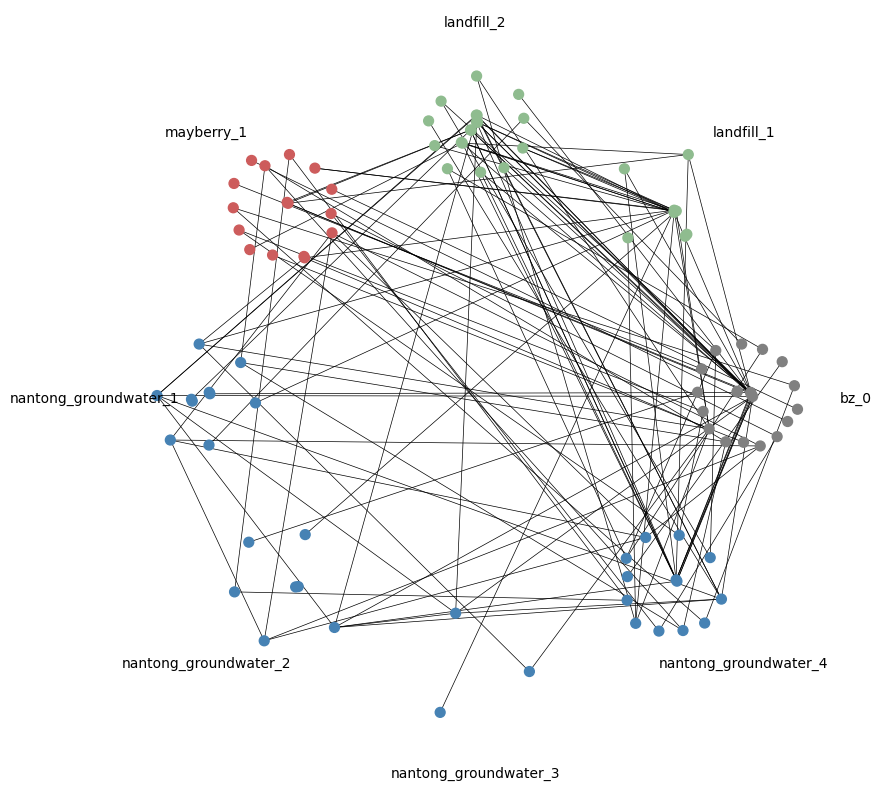

In [15]:
import networkx as nx

def _get_circle_coordinates(radius:int=5, n:int=4):
    coords = list()
    for theta in np.linspace(0, 2*math.pi, n):
        coords += [(math.cos(theta) * radius, math.sin(theta) * radius, theta)]
    return coords 


coords = dict(zip(genome_ids, _get_circle_coordinates(n=len(genome_ids) + 1)))

colors = dict()
colors['bz_0'] = 'gray'
colors['nantong_groundwater_1'] = 'steelblue'
colors['nantong_groundwater_2'] = 'steelblue'
colors['nantong_groundwater_3'] = 'steelblue'
colors['nantong_groundwater_4'] = 'steelblue'
colors['landfill_1'] = 'darkseagreen'
colors['landfill_2'] = 'darkseagreen'
colors['mayberry_1'] = 'indianred'

def _get_graph_layout(graph, clusters, coords:dict=coords):
    # clusters should be a dictionary mapping genome ID to nodes.
    pos = {} # Store the node positions. 
    for genome_id, nodes in clusters.items():
        sub = graph.subgraph([node for node in nodes if (node in graph)])
        for n, (x, y) in nx.spring_layout(sub, seed=42).items():
            pos[n] = (x + coords[genome_id][0], y +  coords[genome_id][1])
    return pos

def plot_comparison(df, clusters=clusters):
    fig, ax = plt.subplots(figsize=(10, 10))
    graph = nx.Graph()
    for row in df.itertuples():
        graph.add_node(row.query_id, color=colors[row.query_id.split('.')[0]])
        graph.add_node(row.subject_id, color=colors[row.subject_id.split('.')[0]])
        graph.add_edge(row.query_id, row.subject_id, weight=row.bit_score)

    pos = _get_graph_layout(graph, clusters)
    nx.draw_networkx_nodes(graph, pos, ax=ax, node_size=50, node_color=[data.get('color') for _, data in graph.nodes(data=True)])
    # weights = [np.log10(graph[u][v]['weight']) for u, v in graph.edges()]
    nx.draw_networkx_edges(graph, pos, ax=ax, width=0.5)
    # nx.draw_networkx_edges(graph, pos, width=weights, ax=ax)
    
    for _, spine in ax.spines.items():
        spine.set_visible(False)

    return ax 


ax = plot_comparison(df)
for genome_id, coord in coords.items():
    coord = coord[0] + 2 * math.cos(coord[-1]), coord[1] + 2 * math.sin(coord[-1])
    ax.text(*coord, genome_id, ha='center', va='center')
plt.show()

    




In [24]:
contigs_df[contigs_df.location == 'mayberry']

,description,seq,strand_bias,n_strand_switches,n_genes,length,gc_content,n_hits,hits,location
id,,,,,,,,,,
Mayberry_contig_91_7252045_length_5790_multi_2_in_0_out_0,"id=31278578 bin=""mayberry_UNK""",GTATTAATTGAGATAAAATATAATATCATTCTTGTAATTGGATGAC...,1.0,0,12,5790,0.232297,10,bz_0.1_31 bz_0.1_35 bz_0.1_29 bz_0 bz_0.1_30 b...,mayberry


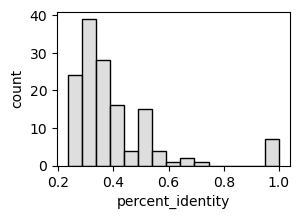

nantong_groundwater_2.8_1, nantong_groundwater_1.2_4
nantong_groundwater_2.9_1, nantong_groundwater_3.14_1
nantong_groundwater_2.9_1, nantong_groundwater_1.2_1
nantong_groundwater_3.14_1, nantong_groundwater_1.2_1
landfill_2.1_1, landfill_2.10_1
landfill_2.1_12, landfill_2.3_1
bz_0.1_1, bz_0.1_38


In [17]:
fig, ax = plt.subplots(figsize=(3, 2))
figure_df = df.copy()
sns.histplot(figure_df, x='percent_identity', color='lightgray')
ax.set_ylabel('count')
plt.show()

for row in figure_df[figure_df.percent_identity > 0.8].itertuples():
    print(f'{row.query_id}, {row.subject_id}') #\t{row.bit_score:.2f}\t{row.percent_identity * 100:.2f}%')
# nantong_groundwater_3.14_1 seems like DNA polymerase. 
# nantong_groundwater_2.8_1 is maybe a packaging NTPase.

In [18]:
df[(df.query_genome_id == df.subject_genome_id) & (df.query_genome_id == 'landfill_1')]
df[df.query_id == 'nantong_groundwater_2.8_1']

,query_id,subject_id,raw_score,bit_score,query_length,subject_length,alignment_length_no_gaps,n_matches,query_genome_id,subject_genome_id,query_contig_id,subject_contig_id,percent_identity
36665,nantong_groundwater_2.8_1,nantong_groundwater_1.2_4,340,158.883883,247,65,65,65,nantong_groundwater_2,nantong_groundwater_1,nantong_groundwater_2.8,nantong_groundwater_1.2,1.000000
36784,nantong_groundwater_2.8_1,bz_0.1_35,441,205.220362,247,256,236,94,nantong_groundwater_2,bz_0,nantong_groundwater_2.8,bz_0.1,0.398305


In [19]:
blast_df[(blast_df.location == 'landfill') & (blast_df.alignment_length > 100)] #.contig_id.unique().tolist()

# contig_id, coverage, gc_content, unidirectional

# mayberry 

# Mayberry_contig_91_7252045_length_5790_multi_2_in_0_out_0, '1.00x', '23.23% 
# Mayberry_contig_81_7972910_length_2564_multi_1_in_0_out_0, '1.00x', '29.95%' # This one has a bacterial taxonomy winner. 
# Mayberry_contig_71_13479747_length_4114_multi_2_in_0_out_0, '1.00x', '33.08%' # Bacterial taxonomy winner, unlikely to be ECE. 
# Mayberry_contig_61_15338014_length_3277_multi_2_in_0_out_0, '1.00x', '48.70%' # Bacterial taxonomy winner and GC content too high. 

# nantong_groundwater

# Nantong_Groundwater_SRR22387873_scaffold_1350, '64.91x', '20.87%', 'yes' # This is >19kb, has genes matching Green Borg and Methanoperedens. No annotated DNA polyB.
# Nantong_Groundwater_SRR22387873_scaffold_376414, '12.80x', '22.82%', 'yes' # This has the DNA polymerase. # Possibly coverage is off because of length?
# Nantong_Groundwater_SRR22387873_scaffold_2044, '41.60x, '21.15%', 'maybe # Has a Methanoperedens gene and a DNA polymerase B. Could there be two? Genes mos
# Nantong_Groundwater_SRR22387873_scaffold_2072, '32.76x', '33.83%', 'no' # 15kb, also has a Methanoperedens gene. Has a phage helicase, and genes are not all in one orientation. 
# Nantong_Groundwater_SRR22387873_scaffold_155357, '15.28x', '22.80%', 'maybe' # Good candidate, has a transcriptional regulator MarR. 
# Nantong_Groundwater_SRR22387873_scaffold_90561, '5.36x', '23.35%', 'maybe' # Has the DNA polyB. Possibly low coverage because only 2kb. 
# Nantong_Groundwater_SRR22387873_scaffold_97929, '12.71x', '32.74%', 'maybe'
# Nantong_Groundwater_SRR22387873_scaffold_99820, '4.75x', '25.96%', 'maybe' # Possibly low coverage because <2kb. 
# Nantong_Groundwater_SRR22387873_scaffold_346753, '23.07x', '22.06%', 'maybe' # Has the DNA polyB, but not much else. 
# Nantong_Groundwater_SRR22387873_scaffold_290644, '22.56x', '22.69%', 'maybe' # Just the DNA polyB. 





,feature_number,feature_id,subject_length,bit_score,e_value,n_identical,alignment_length,n_gaps,percent_identity,query_id,query_length,database,query_coverage,location,contig_id
429,1739026018,Landfill_SRR22315506_METASPADES_scaffold_9110_4,1533,104.0,1.00,161,228,3,0.706140,bz_0.1_25,1842,ggkbase,0.122150,landfill,Landfill_SRR22315506_METASPADES_scaffold_9110
76,1740926841,Landfill_SRR22315506_METASPADES_scaffold_482383_3,264,168.0,1.00,170,227,21,0.748899,bz_0.1_37,276,ggkbase,0.746377,landfill,Landfill_SRR22315506_METASPADES_scaffold_482383
439,1742069501,Landfill_SRR22315506_METASPADES_scaffold_989644_1,1092,50.0,0.33,88,125,9,0.704000,bz_0.1_24,354,ggkbase,0.327684,landfill,Landfill_SRR22315506_METASPADES_scaffold_989644
464,1740993281,Landfill_SRR22315506_METASPADES_scaffold_508684_2,720,49.1,0.70,105,150,23,0.700000,bz_0.1_22,231,ggkbase,0.549784,landfill,Landfill_SRR22315506_METASPADES_scaffold_508684
1447,3157324324,Landfill_SRR22315509_scaffold_178541_1,1929,205.0,4.00,771,1168,90,0.660103,bz_0.1_20,1854,ggkbase,0.581446,landfill,Landfill_SRR22315509_scaffold_178541
1461,3158378469,Landfill_SRR22315509_scaffold_583180_1,846,86.9,3.00,82,105,0,0.780952,bz_0.1_20,1854,ggkbase,0.056634,landfill,Landfill_SRR22315509_scaffold_583180


In [20]:
blast_df[blast_df.contig_id == 'Nantong_Groundwater_SRR22387873_scaffold_1350']

,feature_number,feature_id,subject_length,bit_score,e_value,n_identical,alignment_length,n_gaps,percent_identity,query_id,query_length,database,query_coverage,location,contig_id
427,3333518966,Nantong_Groundwater_SRR22387873_scaffold_1350_27,450,150.0,2.000,260,373,20,0.697051,bz_0.1_26,432,ggkbase,0.817130,nantong_groundwater,Nantong_Groundwater_SRR22387873_scaffold_1350
429,3333518968,Nantong_Groundwater_SRR22387873_scaffold_1350_29,996,58.1,0.007,72,99,0,0.727273,bz_0.1_28,990,ggkbase,0.100000,nantong_groundwater,Nantong_Groundwater_SRR22387873_scaffold_1350
428,3333518971,Nantong_Groundwater_SRR22387873_scaffold_1350_32,462,139.0,1.000,198,277,4,0.714801,bz_0.1_31,450,ggkbase,0.606667,nantong_groundwater,Nantong_Groundwater_SRR22387873_scaffold_1350
244,3333518976,Nantong_Groundwater_SRR22387873_scaffold_1350_37,750,335.0,1.000,526,745,6,0.706040,bz_0.1_35,771,ggkbase,0.958495,nantong_groundwater,Nantong_Groundwater_SRR22387873_scaffold_1350
437,3333518969,Nantong_Groundwater_SRR22387873_scaffold_1350_30,294,53.6,0.023,50,64,0,0.781250,bz_0.1_29,309,ggkbase,0.207120,nantong_groundwater,Nantong_Groundwater_SRR22387873_scaffold_1350
357,3333518970,Nantong_Groundwater_SRR22387873_scaffold_1350_31,681,333.0,4.000,417,567,4,0.735450,bz_0.1_30,684,ggkbase,0.823099,nantong_groundwater,Nantong_Groundwater_SRR22387873_scaffold_1350
426,3333518965,Nantong_Groundwater_SRR22387873_scaffold_1350_26,366,150.0,1.000,211,292,12,0.722603,bz_0.1_24,354,ggkbase,0.790960,nantong_groundwater,Nantong_Groundwater_SRR22387873_scaffold_1350
415,3333518978,Nantong_Groundwater_SRR22387873_scaffold_1350_39,585,251.0,3.000,396,558,21,0.709677,bz_0.1_36,591,ggkbase,0.908629,nantong_groundwater,Nantong_Groundwater_SRR22387873_scaffold_1350


In [21]:


# Nantong_Groundwater_SRR22387873_scaffold_5778, '572.45x', '44.08%' # Seems likely a Borg or Borg fragment. 
# Nantong_Groundwater_SRR22387873_scaffold_23265, '159.52x', '38.19%', 'maybe' # GC content too high. 
# Nantong_Groundwater_SRR22387873_scaffold_27807 # Definitely not. 
# Nantong_Groundwater_SRR22387873_scaffold_60299 # Likely bacterial, and GC content too high. 
# Nantong_Groundwater_SRR22387873_scaffold_49841, '7.03x', ' 30.50%', 'maybe' # Lots of archaeal genes, including an oxioreductase. Probably an archaeal genome fragment. 
# Nantong_Groundwater_SRR22387873_scaffold_5778 # Likely bacterial, high GC content. 
# Nantong_Groundwater_SRR22387873_scaffold_365155 # GC content is too high, and has a bacterial hydrolase.
# Nantong_Groundwater_SRR22387873_scaffold_136593 # GC content almost 40% and only has a methyltranferase that might be bacterial. 
# Nantong_Groundwater_SRR22387873_scaffold_208350 # Probably CPR. 



# landfill


# Landfill_SRR22315509_scaffold_178541, '6.87x', '21.51%', 'maybe' # DNA polymerase is there, but classified as Agrocybe aegerita (a mushroom)
# Landfill_SRR22315509_scaffold_583180, '4.68x', '21.73%', 'maybe' # DNA polymerase B, but assigned mushroom taxonomy as well. 

# Landfill_SRR22315506_METASPADES_scaffold_482383, '2.78x', '38.47%', 'maybe'
# Landfill_SRR22315506_METASPADES_scaffold_508684, '3.56x', '16.76%', 'maybe' # Has only viral and bacterial genes, and seems too low GC content. 
# Landfill_SRR22315506_METASPADES_scaffold_904028, '3.17x', '27.76%', 'maybe' # Gene annotated as belonging to Methanotorris. 

# Landfill_SRR22315509_scaffold_506110 # Likely bacterial, GC content way too high. 
# Landfill_SRR22315506_METASPADES_scaffold_434785 # Taxonomy match to a bacterium, GC content is way too high. 
# Landfill_SRR22315506_METASPADES_scaffold_989644 # GC content seems too high, only one gene annotated and is classified as bacterial. 
# Landfill_SRR22315506_METASPADES_scaffold_482383 # GC content almost 40%
# Landfill_SRR22315506_METASPADES_scaffold_9110 # 16kb, but GC content is almost 40%. Two genes annotated as Methanosarcina. Also has a phage recombinase.
# Landfill_SRR22315506_METASPADES_scaffold_898617 # Has rpsA. 
